# Policy Gradient on linear quadratic problem
In this notebook, we run the policy gradient algorithm on a linear quadratic (LQ) control problem. 
* [You can read about the linear quadratic problem here](linear_quadratic.ipynb)
* [You can read about policy gradient here.](pg_notebook.ipynb)
* [You can see the pure code for policy gradient on the LQ here.](./lq/pg_on_lq.py)

## Summary of the algorithm
We consider a linear policy, so the mean of the pdf is selected as $\mu_{\theta}(s) =\theta \: s$. Then, we iteratively improve the policy. In each iteration of the algorithm, we do the following

* i. We collect a number of batches. Each batch contains a rollout to collect data for PG by following these steps:
    * i.a. We initialize empty histories for `states=[]`, `actions=[]`, `rewards=[]`
    * i.b. We observe the `state` $s$ and sample `action` $a$ from the poliy pdf $\pi_{\theta}(s)$
    
    `a = theta s + sigma * np.random.randn(n_a)`
    
    * i.c. We derive the environment using $a$ and observe the `reward` $r$.
    * i.d. We add $s,\:a,\:r$ to the history batch `states`, `actions`, `rewards`.
    * i.e. We continue from i.b. until the episode ends.
* ii. We improve the policy by following these steps
    * ii.a. We calculate the reward and standardize it. 
    * ii.b. We calculate the gradient using
        \begin{align*}\nabla_{\theta} J = \dfrac{1}{\sigma^2 |\mathcal{D}|}\sum_{\tau \in \mathcal{D}} \sum_{k=0}^{T}(a_k-\theta \: s_k)s^T R(\tau).
        \end{align*}
    
    * ii.c. We update the parameter (here by an ADAM optimizer).

## Running on google colab
If you want to run on google colab, go ahead and run the following cell. If you want to run on your computer, skip this cell and start from Importing libraries.

In [ ]:
!git clone https://github.com/FarnazAdib/Crash_course_on_RL.git
%cd Crash_course_on_RL
!pip install .

## Importing libraries
First, we import the required libraries. If you get an error, you have possibly forgotten to change the kernel. See [Prepare a virtual environment](Preparation.ipynb).

In [1]:
import numpy as np
from lq.dynamics import Linear_Quadratic
from lq.storing_matrices import Storing_Mat, Storing_Mat_opt
from lq.pltlib import PLTLIB
from lq.policies import LinK
from lq.funlib import ADAM

## Making the environment
We select the random seed and make the linear quadratic problem. We also initialize the controller gain `K0`.


In [2]:
rand_seed = 1
np.random.seed(rand_seed)
A = np.array([[1.0, 1.0], [0.0, 1.0]])
B = np.array([[0.0], [1.0]])
x0 = np.array([[-1.0, 0.0]], dtype='float32')
ep = 0.1
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])

Mysys = Linear_Quadratic(A, B, Q, R, x0, ep)
_, K0 = Mysys.lqr_gain(200*Mysys.Q, Mysys.R)

## Making the policy gradient agent
We define the policy gradient class here.

In [3]:
class PGRL:
    def __init__(self, sysdyn:Linear_Quadratic):
        # self.rand_seed = 1
        # np.random.seed(self.rand_seed)
        self.dyn = sysdyn
        self.n, self.m = self.dyn.B.shape

    def safeK(self, K, safeguard):
        if np.isnan(K).any():
            K = safeguard * np.ones((self.m, self.n))
        return K


    def pg_linpolicy(self, K0, N, batch_size, T, explore_mag=0.1,
                     step_size=0.1, beta1=0.9, beta2=0.999, epsilon=1.0e-8, safeguard=10):
        '''
        The policy gradient algorithm where the policy is considered to be linear. We use ADAM optimization.
        :param K0: The initial controller gain
        :param N: Number of iterations
        :param batch_size: number of batches per each step of optimization
        :param T: Trajectory length
        :param explore_mag: Magnitude of the noise to explore
        :param step_size: learning rate for Adam
        :param beta1: Adam related parameter
        :param beta2: Adam related parameter
        :param epsilon: Adam related parameter
        :param safeguard: The maximum absolute value of entries of the controller gain
        :return: The controller gain K
        '''

        # Initialize the controller
        Lin_gain = LinK(K0)
        Lin_gain.make_sampling_on(explore_mag)

        # A heuristic baseline to decrease the variance
        baseline = 0.0

        # Initializing Adam optimizer
        adam = ADAM(self.m, self.n, step_size=step_size, beta1=beta1, beta2=beta2, epsilon=epsilon)

        # start iteration
        for k in range(N):
            batch = np.zeros((self.m, self.n))
            reward = np.zeros(batch_size)

            # In each iteration, collect batches
            for j in range(batch_size):

                # Do one rollout
                states, actions, costs, _ = self.dyn.one_rollout(Lin_gain.sample_lin_policy, T)

                # Building the gradient of the loss with respect to gain
                actions_randomness = actions - Lin_gain.lin_policy(states)
                reward[j] = -np.sum(costs)/T
                batch += explore_mag**(-2) * ((reward[j] - baseline) / batch_size) * actions_randomness.T @ states

            # Update the baseline when batches are collected
            baseline = np.mean(reward)

            # Update the policy using ADAM
            dK = adam.opt_onestep(batch)
            Lin_gain.K += dK
        return self.safeK(Lin_gain.K, safeguard)


We have built the PG class. It remains to build an object from this class. You can change the following hyper parameters if you like

* `T`: The trajectory length
* `n_iteration`: Number of iterations
* `n_batch`: Number of batches in each iteration of the optimization
* `n_monte_carlo`: Number of monte carlo to analyze the performance of the PG
* `step_size`: learning rate for Adam
* `beta1`: beta1 in Adamp optimization
* `beta2`: beta2 in Adam optimization
* `epsilon`: epsilon in Adam optimization
* `safeguard`: The maximum absolute value of entries of the controller gain


In [4]:
Mypgrl = PGRL(Mysys)
T = 10
n_iteration = np.array([0, 500])
n_batch = 8  # Number of batches
n_monte_carlo = 10  # Number of montecarlo

We initialize some matrices to store the results of the algorithms for different numbers of iterations and monte carlo evaluation.

In [5]:
OPT = Storing_Mat_opt("Optimal Solution", Mysys, n_monte_carlo, len(n_iteration))
PG = Storing_Mat("Policy Gradient", Mysys, K0, n_monte_carlo, len(n_iteration))
Methods = [PG]

## Start learning
Now, we evaluate the performance of the policy gradient on the LQ problem. The algorithm is run for the number of iterations given in the `n_iteration` array. We also repeat the simulation for `n_monte_carlo` times and report the mean value for the parameters and errors to reduce the effect of randomness on our learning. In practice, you need to use a larger `n_monte_carlo ` than 10. We have chosen 10 to get the results fast. The policy gradient algorithm returns the estimated gain $\bar{K}$. In the second loop below, we compute the finite average cost, infinite average cost and the error from the exact $K_{opt}$.

In [6]:
for N in range(1, len(n_iteration)):
    for trial in range(n_monte_carlo):
        print('Number of iterations: %d, MC trial: %d' % (n_iteration[N], trial))

        print('Policy Gradient')
        PG.K[:, :, trial, N] = Mypgrl.pg_linpolicy(K0, n_iteration[N], n_batch, T)


for N in range(1, len(n_iteration)):
    for trial in range(n_monte_carlo):
        OPT.J_fin[trial, N] = Mysys.cost_finite_average_K(OPT.K, T)
        for meth in Methods:
            meth.J_inf[trial, N] = Mysys.cost_inf_K(meth.K[:, :, trial, N])
            meth.J_fin[trial, N] = Mysys.cost_finite_average_K(meth.K[:, :, trial, N], T)
            meth.Ke[trial, N] = Mysys.dist_from_optimal_K(meth.K[:, :, trial, N])

Number of iterations: 500, MC trial: 0
Policy Gradient
Number of iterations: 500, MC trial: 1
Policy Gradient
Number of iterations: 500, MC trial: 2
Policy Gradient
Number of iterations: 500, MC trial: 3
Policy Gradient
Number of iterations: 500, MC trial: 4
Policy Gradient
Number of iterations: 500, MC trial: 5
Policy Gradient
Number of iterations: 500, MC trial: 6
Policy Gradient
Number of iterations: 500, MC trial: 7
Policy Gradient
Number of iterations: 500, MC trial: 8
Policy Gradient
Number of iterations: 500, MC trial: 9
Policy Gradient


## Results
We plot the result of the simulation here. The first figure shows the fraction of times the algorithm returns stable policies in all iterations. The second figure shows the error between the estimated gain and the optimal gain; $K_e =\frac{||\bar{K}-K_{opt}||}{||K_{opt}||}$. The third figure shows the error between the infinite average costs by the estimated controller gain and the optimal controller $K_e =\frac{||\bar{J}-J_{opt}||}{||J_{opt}||}$. In all three figures, the zero iteration refers to the initiation of the algorithm. 

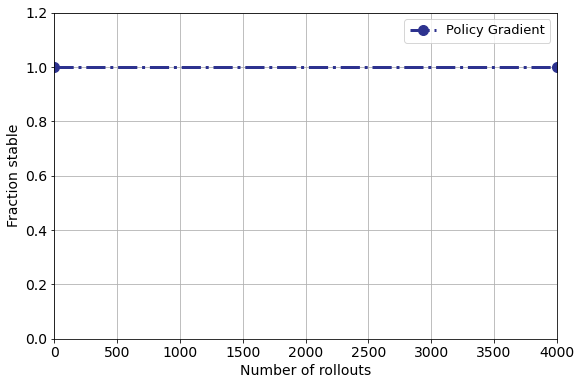

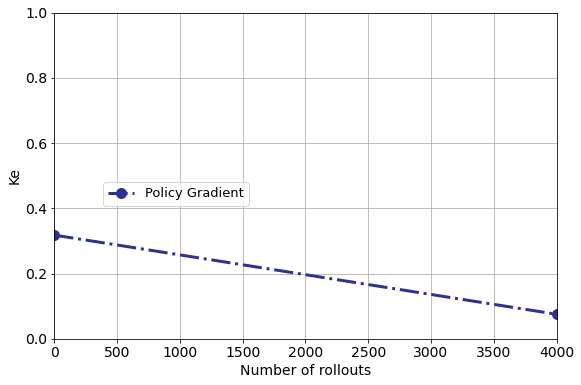

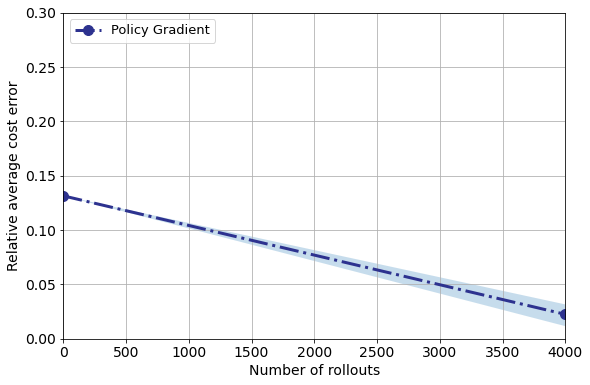

In [7]:
MyPlot = PLTLIB(OPT.J_inf)
J = [meth.J_inf for meth in Methods]
Lab = [meth.name for meth in Methods]
MyPlot.frac_stable(J, n_batch * n_iteration, n_monte_carlo, Lab, 'Number of rollouts')
MyPlot.est_e([meth.Ke for meth in Methods], n_batch * n_iteration, Lab, 'Number of rollouts', "Ke", 1)
MyPlot.relative_inf_cost(J, n_batch * n_iteration, Lab, 'Number of rollouts', uplim=0.3, zoomplt=False)

We print the estimated controller gain with the policy gradient and compare it with the analytical optimal solution.

In [8]:
print('\nThe optimal k \n', OPT.K)
for meth in Methods:
    print('\nMean of estimated K using', meth.name, '\n', np.mean(meth.K[:, :, :, -1], axis=2))

for meth in Methods:
    print('\nMedian of Ke using', meth.name, np.median(meth.Ke[:, -1]))


The optimal k 
 [[-0.42208244 -1.24392885]]

Mean of estimated K using Policy Gradient 
 [[-0.43756554 -1.21308291]]

Median of Ke using Policy Gradient 0.07528689639766774


The median of $K_e$ will be around $7-14\%$. You can play with the hyper parameters to see if you can get a better result. In general, the plain PG algorithm does not produce good result. To the best of my knowledge, [the convergence of the PG algorithm for LQ problem is only proved for the deterministic LQ problem with stochastic initial conditions.](https://openreview.net/pdf?id=BJDEbngCZ) Usually, PG is combined with other methods (for example dynamic programming which results in actor-critic networks) to produce good results or the baseline should be selected properly.